## Predicting FICO Scores

##### Author: Chase Renick
##### Date: 7/2019
##### Project: Financial DS Test

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from warnings import simplefilter
import matplotlib.pyplot as plt
%matplotlib inline

### Reading in File

In [2]:
df = pd.read_csv("C:/Users/CRENICK/Desktop/Wallet/dataset_00_with_header.csv")

In [3]:
df.shape

(100000, 305)

In [4]:
df.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
0,1540332,NaN,NaN,NaN,8.0,1,0,1,0,0,...,0,NaN,0,0,0,0,NaN,0,NaN,706
1,823066,4.0,3.0,3.0,4.0,0,2,2,0,0,...,5206,0.9339,1,1,1,0,NaN,0,NaN,558
2,1089795,NaN,NaN,NaN,96.0,1,0,0,0,1,...,0,NaN,0,0,0,0,NaN,0,NaN,577
3,1147758,63.0,14.0,38.0,258.0,0,0,0,1,2,...,0,NaN,1,1,1,0,NaN,0,NaN,526
4,1229670,34.0,25.0,29.0,34.0,1,0,0,0,3,...,0,NaN,0,0,0,0,NaN,0,NaN,496


#### Dataset Basics
1. Making assumption that x001 is the contract / customer primary key for a the dataset
2. Many NaN values 
3. Various flags indicated by 0 or 1 regarding customer
4. 303 independent features when you elminate the contract number and predictor variable (y)
4. Dependent Variable (y) seems to be FICO score

Overall, it appears that this dataset relates to customers at Wallethub, a number of customer features related to what drives their FICO score, and the predictor variable (y) seems to be their FICO score.

### Initial Insights

#### DataTypes

In [5]:
set(list(df.dtypes.unique()))

{dtype('int64'), dtype('float64')}

Fortunately for us, the datatypes within this dataset are of the type int64 and float64, which avoids us having to manipulate strings, objects, datetime, etc.  

The fact that this dataset is likely a financial dataset, we can safely assume thta the features either represent some real value (like total monthly earnings, downpayment, etc), or some categorical feature (like a age group, ethnicity, flag, etc.)

#### Features
However, since we do not know what exactly the features are within this data set, before building any model we must recognize that some features may be categorical and others non-categorical.  Categorical features often refer to look up tables and thus have to be one hot encoded if they are to be incorporated into the model.  

Take for example the feature x010:

In [6]:
print ("Feature: x010","\nMin:", min(df['x010']), "\nMax:", max(df['x010']))

Feature: x010 
Min: 0 
Max: 33


X010 has a minimum of 0 and a maximum of 33. These values likely refer to 0-33 categories related to the customer such as their ethnicity, or perhaps they are buckets for their total household income.  We cannot definitiely say if this or any other feature is categorical or non-categorical, so I will specify some assumptions regarding which features are what.

In [7]:
df.describe()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
count,1.000000e+05,78568.000000,78568.000000,78576.000000,93890.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,1.000000e+05,41888.000000,100000.000000,100000.000000,100000.000000,100000.000000,26931.000000,100000.000000,18125.000000,100000.000000
mean,1.218244e+06,125.711727,25.541238,65.393212,178.238545,0.314040,0.694000,1.388220,1.192980,1.026990,...,1.181960e+04,0.794034,0.543320,0.558030,0.581830,0.106240,2.948758,6410.882910,1.037957,619.198230
std,2.728977e+05,115.785117,49.028751,63.592317,124.520628,0.464135,1.379378,2.282805,2.031083,1.713823,...,3.226469e+04,0.288249,0.498122,0.496624,0.493261,0.308146,2.129430,24190.243313,0.330580,118.461932
min,5.170000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,300.000000
25%,9.743635e+05,32.000000,3.000000,19.000000,87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.636900,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.975800,524.000000
50%,1.235926e+06,100.000000,8.000000,48.000000,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.851000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.048600,599.000000
75%,1.445326e+06,180.000000,24.000000,92.000000,246.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,1.295600e+04,0.982000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000,1.186200,720.000000
max,1.677197e+06,718.000000,704.000000,704.000000,827.000000,1.000000,44.000000,108.000000,81.000000,33.000000,...,2.696702e+06,13.035300,1.000000,1.000000,1.000000,1.000000,9.000000,785537.000000,5.156900,839.000000


#### Missing Values

Given that there are many Nan values within the dataset, we will now examine how many features contain NaNs.

In [8]:
#Total number of nans within the dataset (we don't want the contract number or dependent variable)
total_nans = df.iloc[:,1:-1].isnull().sum().sum()
print ("Total Nans: ", total_nans)

r,c = (df.iloc[:,1:-1].shape)
total_values = r*c

print ("Percentage of NaNs values in dataset:", round(total_nans/total_values,3)*100,"%")

Total Nans:  2034451
Percentage of NaNs values in dataset: 6.7 %


In [9]:
#Examining how many columns contain nan values
nan_df = df.iloc[:,1:-1].isna().sum(axis=0).reset_index().rename(columns={'index':'features', 0:'nan_count'})

#Determining what percentage of the column contains empty values
nan_df['nan_percentage'] = (nan_df['nan_count'] / 100000)

#### Overall Nan Insights

In [10]:
a, b = (nan_df[nan_df['nan_count']>0].shape)
a2, b2 = (nan_df[nan_df['nan_percentage']>.49].shape)
print ("There are", a, "features that contain at least one nan value.")
print ("Of those", a, "features",a2, "features have more than 49% of the values missing.")

There are 41 features that contain at least one nan value.
Of those 41 features 22 features have more than 49% of the values missing.


In [11]:
print (round(a/c,3)*100, "% of the all the features from this dataset contain at least one missing values")
print (round(a2/c,3)*100, "% of the all the features from this dataset contain more than 49% missing values")

13.5 % of the all the features from this dataset contain at least one missing values
7.3 % of the all the features from this dataset contain more than 49% missing values


In [12]:
#Deeper dive into the columns with Nans
nan_df[nan_df['nan_count']>0]

,features,nan_count,nan_percentage
0,x002,21432,0.21432
1,x003,21432,0.21432
2,x004,21424,0.21424
3,x005,6110,0.06110
39,x041,36872,0.36872
42,x044,19674,0.19674
43,x045,19674,0.19674
55,x057,36872,0.36872
56,x058,36872,0.36872
96,x098,80681,0.80681


#### Assumptions with Nans:

So we know that 13.5% of all the features contain some missing value, but approximately 7% of all the features have more the 49% of the values missing. 49% is a pretty significant percentage to be missing data from a feature, so for the purposes of this analysis, we will make the assumption that these features are missing enough information that our imputing techniques may artificially throw the model off.  In other words, we are going to remove 22 features from the dataset which will leave us with 281 features for our model to potentially learn from.

For the other 19 features (41-22) which are still missing data, but have at least 51% available, we will use some imputation techniques to generate possible values for this missing data.

## Preprocessing

#### Removing Features with more than 49% missing data

In [13]:
remove_features = list(nan_df[nan_df['nan_percentage']>.49].features)

In [14]:
df2 = df.drop(remove_features,axis=1)
df2.shape

(100000, 283)

In [15]:
df2.head(2)

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x291,x292,x294,x296,x298,x299,x300,x301,x303,y
0,1540332,NaN,NaN,NaN,8.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,706
1,823066,4.0,3.0,3.0,4.0,0,2,2,0,0,...,5206,5206,0,5206,1,1,1,0,0,558


#### Building Dummy Variable Columns 

For the purposes of this project and in the aspect of time, I am going to assume that there are no categorical variables within this data set.  If we knew the features then we would have to be one hot encode them if they were to be used in most machine learning models. Although there are likely some categorical variables within the dataset, I have chosen to treat them as non-categorical. 

### Performing Test Train Split

In [16]:
def tts(df, target):
    """
    INPUT:
    OUTPUT:
    """
    X = df.loc[:, df.columns != str(target)].iloc[:,1:]
    y = df.loc[:, df.columns == str(target)].values.flatten()
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(X, y, indices, test_size=0.2, shuffle=True)

    return X_train, X_test, y_train, y_test, idx1, idx2

In [17]:
X_train, X_test, y_train, y_test, idx1, idx2 = tts(df2,'y')

In [18]:
print (X_train.shape)
print (X_test.shape)

(80000, 281)
(20000, 281)


We can see that we successfully split the training and test set (80/20) based on our specifications outlined in the tts function.

### Scaling and Normalizing for Outliers

In [19]:
def robust_scaling(X_train,X_test):
    """
    INPUT:Training set from X_train, Training set X_test
    OUTPUT: Normalized Scaled versions of the X_train and X_test
    PURPOSE: To normalize / scale data specifically in regards to potential outliers
    """
    std = RobustScaler()
    std.fit(X_train)
    X_train = std.transform(X_train)
    X_test = std.transform(X_test) #Applying the same scaling method to the test set as training set

    return X_train, X_test

In [20]:
X_train, X_test = robust_scaling(X_train, X_test)

Early in our exploratory process we saw that there were some extreme values within some of the features which may skew or bias our data before modeling.  There are multiple normalization techniques, but I chose RobustScaler because it is designed to minimize the impact of outliers on our data set.

### Imputing Values

In [21]:
def imputer(X_train, X_test):
    """
    INPUT:Training set from X_train, Training set X_test
    OUTPUT:Imputing values for the NaNs based on the median of what is contained in the 
    """
    imp = SimpleImputer(strategy='median')
    imp.fit(X_train)
    X_train = imp.transform(X_train)
    X_test = imp.transform(X_test)
    
    return X_train, X_test

In [22]:
Xtr, Xte = imputer(X_train, X_test)

Now that we have split the data and scaled it, we can impute values for the NaNs still contained within our dataset.  Even though we have minimized the impact of outliers, I decided to use the median as the metric to generate estimated values for the NaNs within the data set. Imputing will allow us to not ignore relevant features because we do not have the reamining values.

### Feature Engineering

#### Backwards Elimination

In [25]:
def backwards_elmination(df,target):
        import statsmodels.api as sm
    
        X = df.loc[:, df.columns != str(target)].iloc[:,1:]
        y = df[str(target)].values
        cols = list(X.columns)
        
        imp = SimpleImputer(strategy='median')
        imp.fit(X)
        X = imp.transform(X)
        
        
        X= pd.DataFrame(X, columns = cols)
        pmax = 1
        while (len(cols)>0):
            p= []
            X_1 = X[cols]
            X_1 = sm.add_constant(X_1)
            model = sm.OLS(y,X_1).fit()
            p = pd.Series(model.pvalues.values[1:],index = cols)      
            pmax = max(p)
            feature_with_p_max = p.idxmax()
            if(pmax>0.05):
                cols.remove(feature_with_p_max)
            else:
                break
        selected_features_BE = cols

        return selected_features_BE

In [26]:
b_features = backwards_elmination(df2,'y')
b_features

C:\Users\CRENICK\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['x002',
 'x003',
 'x004',
 'x005',
 'x006',
 'x010',
 'x011',
 'x013',
 'x014',
 'x015',
 'x016',
 'x017',
 'x018',
 'x019',
 'x020',
 'x021',
 'x022',
 'x023',
 'x024',
 'x025',
 'x026',
 'x027',
 'x029',
 'x030',
 'x031',
 'x032',
 'x034',
 'x036',
 'x038',
 'x040',
 'x041',
 'x042',
 'x043',
 'x045',
 'x046',
 'x048',
 'x049',
 'x050',
 'x051',
 'x052',
 'x053',
 'x054',
 'x055',
 'x056',
 'x057',
 'x058',
 'x059',
 'x061',
 'x062',
 'x063',
 'x066',
 'x069',
 'x073',
 'x074',
 'x076',
 'x078',
 'x080',
 'x082',
 'x085',
 'x087',
 'x088',
 'x089',
 'x090',
 'x091',
 'x092',
 'x097',
 'x100',
 'x101',
 'x104',
 'x106',
 'x107',
 'x110',
 'x111',
 'x113',
 'x117',
 'x120',
 'x132',
 'x137',
 'x144',
 'x146',
 'x147',
 'x148',
 'x149',
 'x153',
 'x154',
 'x159',
 'x161',
 'x164',
 'x168',
 'x169',
 'x171',
 'x172',
 'x174',
 'x175',
 'x176',
 'x179',
 'x180',
 'x183',
 'x185',
 'x188',
 'x193',
 'x194',
 'x199',
 'x207',
 'x208',
 'x222',
 'x223',
 'x225',
 'x228',
 'x229',
 'x231',
 

While backwards elimination normally will help us reduce the number of features, but in this case their are enough statistically significant features that we may want to explore other techniques for measuring the feature importance.

#### Random Forest Regressor:

In [23]:
def randomForestFeatures(df, X_train, y_train):
    
    """
    INPUT:
    OUTPUT:
    PURPOSE:
    """
    names = df.iloc[:,1:-1].columns
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    print ("Features sorted by their score:")
    tups = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))
    print (tups)
    
    return tups

In [24]:
impt_features = randomForestFeatures(df2, Xtr, y_train)

C:\Users\CRENICK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.5146, 'x043'), (0.0927, 'x057'), (0.0762, 'x075'), (0.0719, 'x274'), (0.0242, 'x281'), (0.015, 'x235'), (0.0131, 'x276'), (0.0106, 'x005'), (0.0085, 'x272'), (0.008, 'x055'), (0.0075, 'x044'), (0.0074, 'x014'), (0.0061, 'x006'), (0.0059, 'x099'), (0.0049, 'x181'), (0.0041, 'x041'), (0.004, 'x277'), (0.004, 'x036'), (0.0039, 'x240'), (0.0035, 'x245'), (0.0035, 'x236'), (0.0035, 'x031'), (0.0033, 'x233'), (0.0029, 'x234'), (0.0028, 'x239'), (0.0028, 'x171'), (0.0027, 'x243'), (0.0025, 'x056'), (0.0025, 'x004'), (0.0024, 'x287'), (0.0024, 'x076'), (0.0023, 'x192'), (0.0022, 'x059'), (0.0021, 'x082'), (0.0019, 'x015'), (0.0018, 'x238'), (0.0018, 'x065'), (0.0018, 'x002'), (0.0017, 'x020'), (0.0017, 'x017'), (0.0017, 'x003'), (0.0016, 'x193'), (0.0014, 'x279'), (0.0014, 'x045'), (0.0013, 'x204'), (0.0013, 'x186'), (0.0012, 'x273'), (0.0011, 'x194'), (0.0011, 'x040'), (0.0011, 'x035'), (0.001, 'x303'), (0.001, 'x296'), (0.001, 'x251'), (0.001, 'x237'), (0.

Looking at the feature importance generated from the random forest regressor, we can see that there are only a handfult of features which are driving the model. Let's create a dictionary to see which ones are the most relevant based on a threshold we specify of .005.

In [25]:
def getThresholdDictonary(features, threshold):
    """
    INPUT: The list of tuples generated from the Random Forest Regressor feature extraction, 
    a threshold for what features you want to include
    OUTPUT: A dictionary of the features and their importances, as well as a list of them unordered 
    PURPOSE: To allow for more feature exploration and getting a list of features to filter on when building model
    """
    
    relevant_features = []
    dict = {}
    for i in range(len(features)):
        v,k = (features[i])
        
        if v >= threshold:
            dict[k] = v
            relevant_features.append(k)
            
    return dict, relevant_features
        
feature_dict, relevant_features = getThresholdDictonary(impt_features, .001)
feature_dict

{'x043': 0.5146,
 'x057': 0.0927,
 'x075': 0.0762,
 'x274': 0.0719,
 'x281': 0.0242,
 'x235': 0.015,
 'x276': 0.0131,
 'x005': 0.0106,
 'x272': 0.0085,
 'x055': 0.008,
 'x044': 0.0075,
 'x014': 0.0074,
 'x006': 0.0061,
 'x099': 0.0059,
 'x181': 0.0049,
 'x041': 0.0041,
 'x277': 0.004,
 'x036': 0.004,
 'x240': 0.0039,
 'x245': 0.0035,
 'x236': 0.0035,
 'x031': 0.0035,
 'x233': 0.0033,
 'x234': 0.0029,
 'x239': 0.0028,
 'x171': 0.0028,
 'x243': 0.0027,
 'x056': 0.0025,
 'x004': 0.0025,
 'x287': 0.0024,
 'x076': 0.0024,
 'x192': 0.0023,
 'x059': 0.0022,
 'x082': 0.0021,
 'x015': 0.0019,
 'x238': 0.0018,
 'x065': 0.0018,
 'x002': 0.0018,
 'x020': 0.0017,
 'x017': 0.0017,
 'x003': 0.0017,
 'x193': 0.0016,
 'x279': 0.0014,
 'x045': 0.0014,
 'x204': 0.0013,
 'x186': 0.0013,
 'x273': 0.0012,
 'x194': 0.0011,
 'x040': 0.0011,
 'x035': 0.0011,
 'x303': 0.001,
 'x296': 0.001,
 'x251': 0.001,
 'x237': 0.001,
 'x170': 0.001,
 'x169': 0.001,
 'x024': 0.001,
 'x021': 0.001}

In [26]:
print ("Number of Features to be included in the model: ", len(relevant_features))

Number of Features to be included in the model:  58


In [27]:
#These values are hardcoded after I ran the baseline model a number of times
print ("\nBaseline Model RSME Results:")
print ("Threshold .0001 -> 224 features -> RSME SCORE:", 30.73)
print ("Threshold .001 -> 58 features -> RSME SCORE:", 30.77)
print ("Threshold .003-> 23 features -> RSME SCORE:", 35.01)
print ("Threshold .005-> 14 features -> RSME SCORE:", 36.64)
print ("Threshold .01-> 8 features -> RSME SCORE: ", 42.28)


Baseline Model RSME Results:
Threshold .0001 -> 224 features -> RSME SCORE: 30.73
Threshold .001 -> 58 features -> RSME SCORE: 30.77
Threshold .003-> 23 features -> RSME SCORE: 35.01
Threshold .005-> 14 features -> RSME SCORE: 36.64
Threshold .01-> 8 features -> RSME SCORE:  42.28


After trying a few combinations for how many features to include in the analysis, I decided the .001 because it seemed to be the optimal threshold figure that did not make the model overly complicated to explain or including too many features, yet it maintained essentially the performance of if I had included all the features. 

Below .001, the model still performed fairly well, but it began to lose some of its accuracy in an overly reducing the number of features to less than 10. Information was clearly being lost with a threshold of greater than .001, but not much gained going an order of magnitude lower.

In [28]:
df2[relevant_features].describe()

,x043,x057,x075,x274,x281,x235,x276,x005,x272,x055,...,x040,x035,x303,x296,x251,x237,x170,x169,x024,x021
count,1.000000e+05,63128.000000,100000.000000,1.000000e+05,1.000000e+05,79917.000000,100000.000000,93890.000000,92811.000000,100000.00000,...,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,63256.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.189835e+04,0.652558,2015.256760,4.942003e+03,5.614105e+04,10206.774942,0.256510,178.238545,0.587940,0.34035,...,1.867910,3.143720,6410.882910,1.181960e+04,0.302950,123.803829,0.207390,0.110230,4.733060,2.283170
std,3.950263e+04,0.482736,6377.425012,2.905449e+04,1.705259e+05,11938.474722,0.939979,124.520628,5.392342,0.93129,...,2.191034,5.061691,24190.243313,3.226469e+04,0.644589,125.095034,0.801552,0.523853,7.159681,3.161361
min,-5.003000e+04,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.202300,0.000000,0.000000e+00,0.000000e+00,1000.000000,0.000000,87.000000,0.076400,0.00000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,21.000000,0.000000,0.000000,1.000000,0.000000
50%,3.000000e+02,0.739900,83.000000,0.000000e+00,4.253000e+03,5500.000000,0.000000,150.000000,0.287300,0.00000,...,1.000000,1.000000,0.000000,0.000000e+00,0.000000,83.000000,0.000000,0.000000,2.000000,1.000000
75%,1.038225e+04,0.989900,1874.000000,8.520000e+02,3.570575e+04,16000.000000,0.000000,246.000000,0.571100,0.00000,...,3.000000,4.000000,0.000000,1.295600e+04,0.000000,192.000000,0.000000,0.000000,6.000000,3.000000
max,4.885410e+06,15.660000,458940.000000,2.699159e+06,1.522406e+07,250000.000000,29.000000,827.000000,608.100000,17.00000,...,34.000000,176.000000,785537.000000,2.696702e+06,18.000000,718.000000,28.000000,24.000000,129.000000,84.000000


In [29]:
#Adding label back to the list of relevant features
specific_features = list(relevant_features)
specific_features.append('y')

## Modeling

In [30]:
def specific_tts(df, target):
    """
    INPUT:
    OUTPUT:
    """
    X = df[specific_features[:-1]].values
    y = df.loc[:, df.columns == str(target)].values.flatten()
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(X, y, indices, test_size=0.2, shuffle=True)

    return X_train, X_test, y_train, y_test, idx1, idx2

In [31]:
X_train2, X_test2, y_train2, y_test2, idxtr, idxte = specific_tts(df2,'y') #Splitting
X_train2, X_test2 = robust_scaling(X_train2, X_test2) #Normalizing
Xtr2, Xte2 = imputer(X_train2, X_test2) #Imputing

#### Baseline Model

In [32]:
def basemodel(X_train, y_train, new_dataset):
    """
    INPUT: Xtrain, ytrain, dataset to predict on
    OUTPUT: The predicted results from the new dataset to predict on
    """
    rf_reg = RandomForestRegressor()

    rf_reg.fit(X_train, y_train)

    scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    print(f"10 Folds Cross Validation Bagging: {scores.mean():.3f}")

    return rf_reg.predict(new_dataset)

In [33]:
base_predictions = basemodel(Xtr2, y_train2, Xte2)

C:\Users\CRENICK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


10 Folds Cross Validation Bagging: -960.045


In [34]:
def rsme(actuals, predictions):
    """
    INPUT: Predictions to the model
    OUTPUT: Root mean squared error
    PURPOSE: To measure the performance of the model
    """

    return np.round(np.sqrt(mean_squared_error(actuals, predictions)),2)

In [35]:
rsme(y_test2, base_predictions)

30.65

This is the baseline model rsme results for which we can compare the performance of future models against.  Without any major hyperparameter tuning, it seems to be performing, medicore, but let's see what we can do with some tuning / optimzation techniques.

### HyperParameter Tuning

#### Randomized Search

In [88]:
# Number of Tree Estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 100)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rdfr = RandomForestRegressor() 

rf_random = RandomizedSearchCV(estimator = rdfr, 
                               param_distributions = random_grid, 
                               n_iter = 10, cv = 10, 
                               verbose=2, 
                               random_state= 42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtr2, y_train2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.9min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 103, 106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187, 190, 193, 196, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 233, 236, 239, 242, 245, 248, 251, 254, 25...ne], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, re

#### Gridsearch

In [52]:
cv = StratifiedKFold(n_splits = 10, shuffle=True)

rdf = RandomForestRegressor() 
scoring = {'RSME': make_scorer('mean_squared_error')}

params = {'max_depth': [6, 8, 10, 20], 
          'min_samples_split': [5, 10, 15],
          'min_samples_leaf' : [4, 8, 12],
          'n_estimators' : [100],
          'max_features': ['auto', 'sqrt', 'log2']
         }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(Xtr2, y_train2)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


C:\Users\CRENICK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 94.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 114.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [6, 8, 10, 20], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [4, 8, 12], 'n_estimators': [100], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

### Best Grid Search Results

In [54]:
print(grid_clf.best_params_)
print(grid_clf.best_score_)    

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
0.9373469611307473


Based on these results, we can place these hyperameters into a RandomForestRegressor Model. For the sake of time, I will not put these features in the boosted or bagged model due to time contraints running the model.

#### Boosted Models

In [36]:
def boosted_model(X_train, y_train, new_dataset):
    """
    INPUT: Xtrain, ytrain, dataset to predict on
    OUTPUT: The predicted results from the new dataset to predict on
    """
    rf_reg = RandomForestRegressor(max_depth= 20,
                                    max_features='sqrt',
                                    min_samples_leaf= 4,
                                    min_samples_split= 5,
                                    n_estimators= 100)
    boost_rf_rg = AdaBoostRegressor(base_estimator=rf_reg,
                                             n_estimators=10,
                                             random_state=123)
    boost_rf_rg.fit(X_train, y_train)

#     scores = cross_val_score(boost_rf_rg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
#     print(f"10 Folds Cross Validation Bagging: {scores.mean():.3f}")

    return boost_rf_rg.predict(new_dataset)

In [37]:
boosted_predictions = boosted_model(Xtr2, y_train2, Xte2)

In [38]:
rsme(y_test2, boosted_predictions)

28.41

We can see that boosting the model improves the model performance, and combined with gid search we are approaching a descent RSME score.

In [39]:
def bagged_model(X_train, y_train, new_dataset):
    """
    INPUT: Xtrain, ytrain, dataset to predict on
    OUTPUT: The predicted results from the new dataset to predict on
    """
    rf_reg = RandomForestRegressor(max_depth= 20,
                                    max_features='sqrt',
                                    min_samples_leaf= 4,
                                    min_samples_split= 5,
                                    n_estimators= 100)
    bagged_rf_rg = BaggingRegressor(base_estimator=rf_reg,
                                             n_estimators=10,
                                             random_state=123)
    bagged_rf_rg.fit(X_train, y_train)
    
    return bagged_rf_rg.predict(new_dataset)

In [40]:
bagged_predictions = bagged_model(Xtr2, y_train2, Xte2)

In [41]:
rsme(y_test2,bagged_predictions) 

29.75

Similarly, if we do a similar approach with bagging we see that AdaBoost performs slightly better, so we will used the boosted model. 

#### Correlation

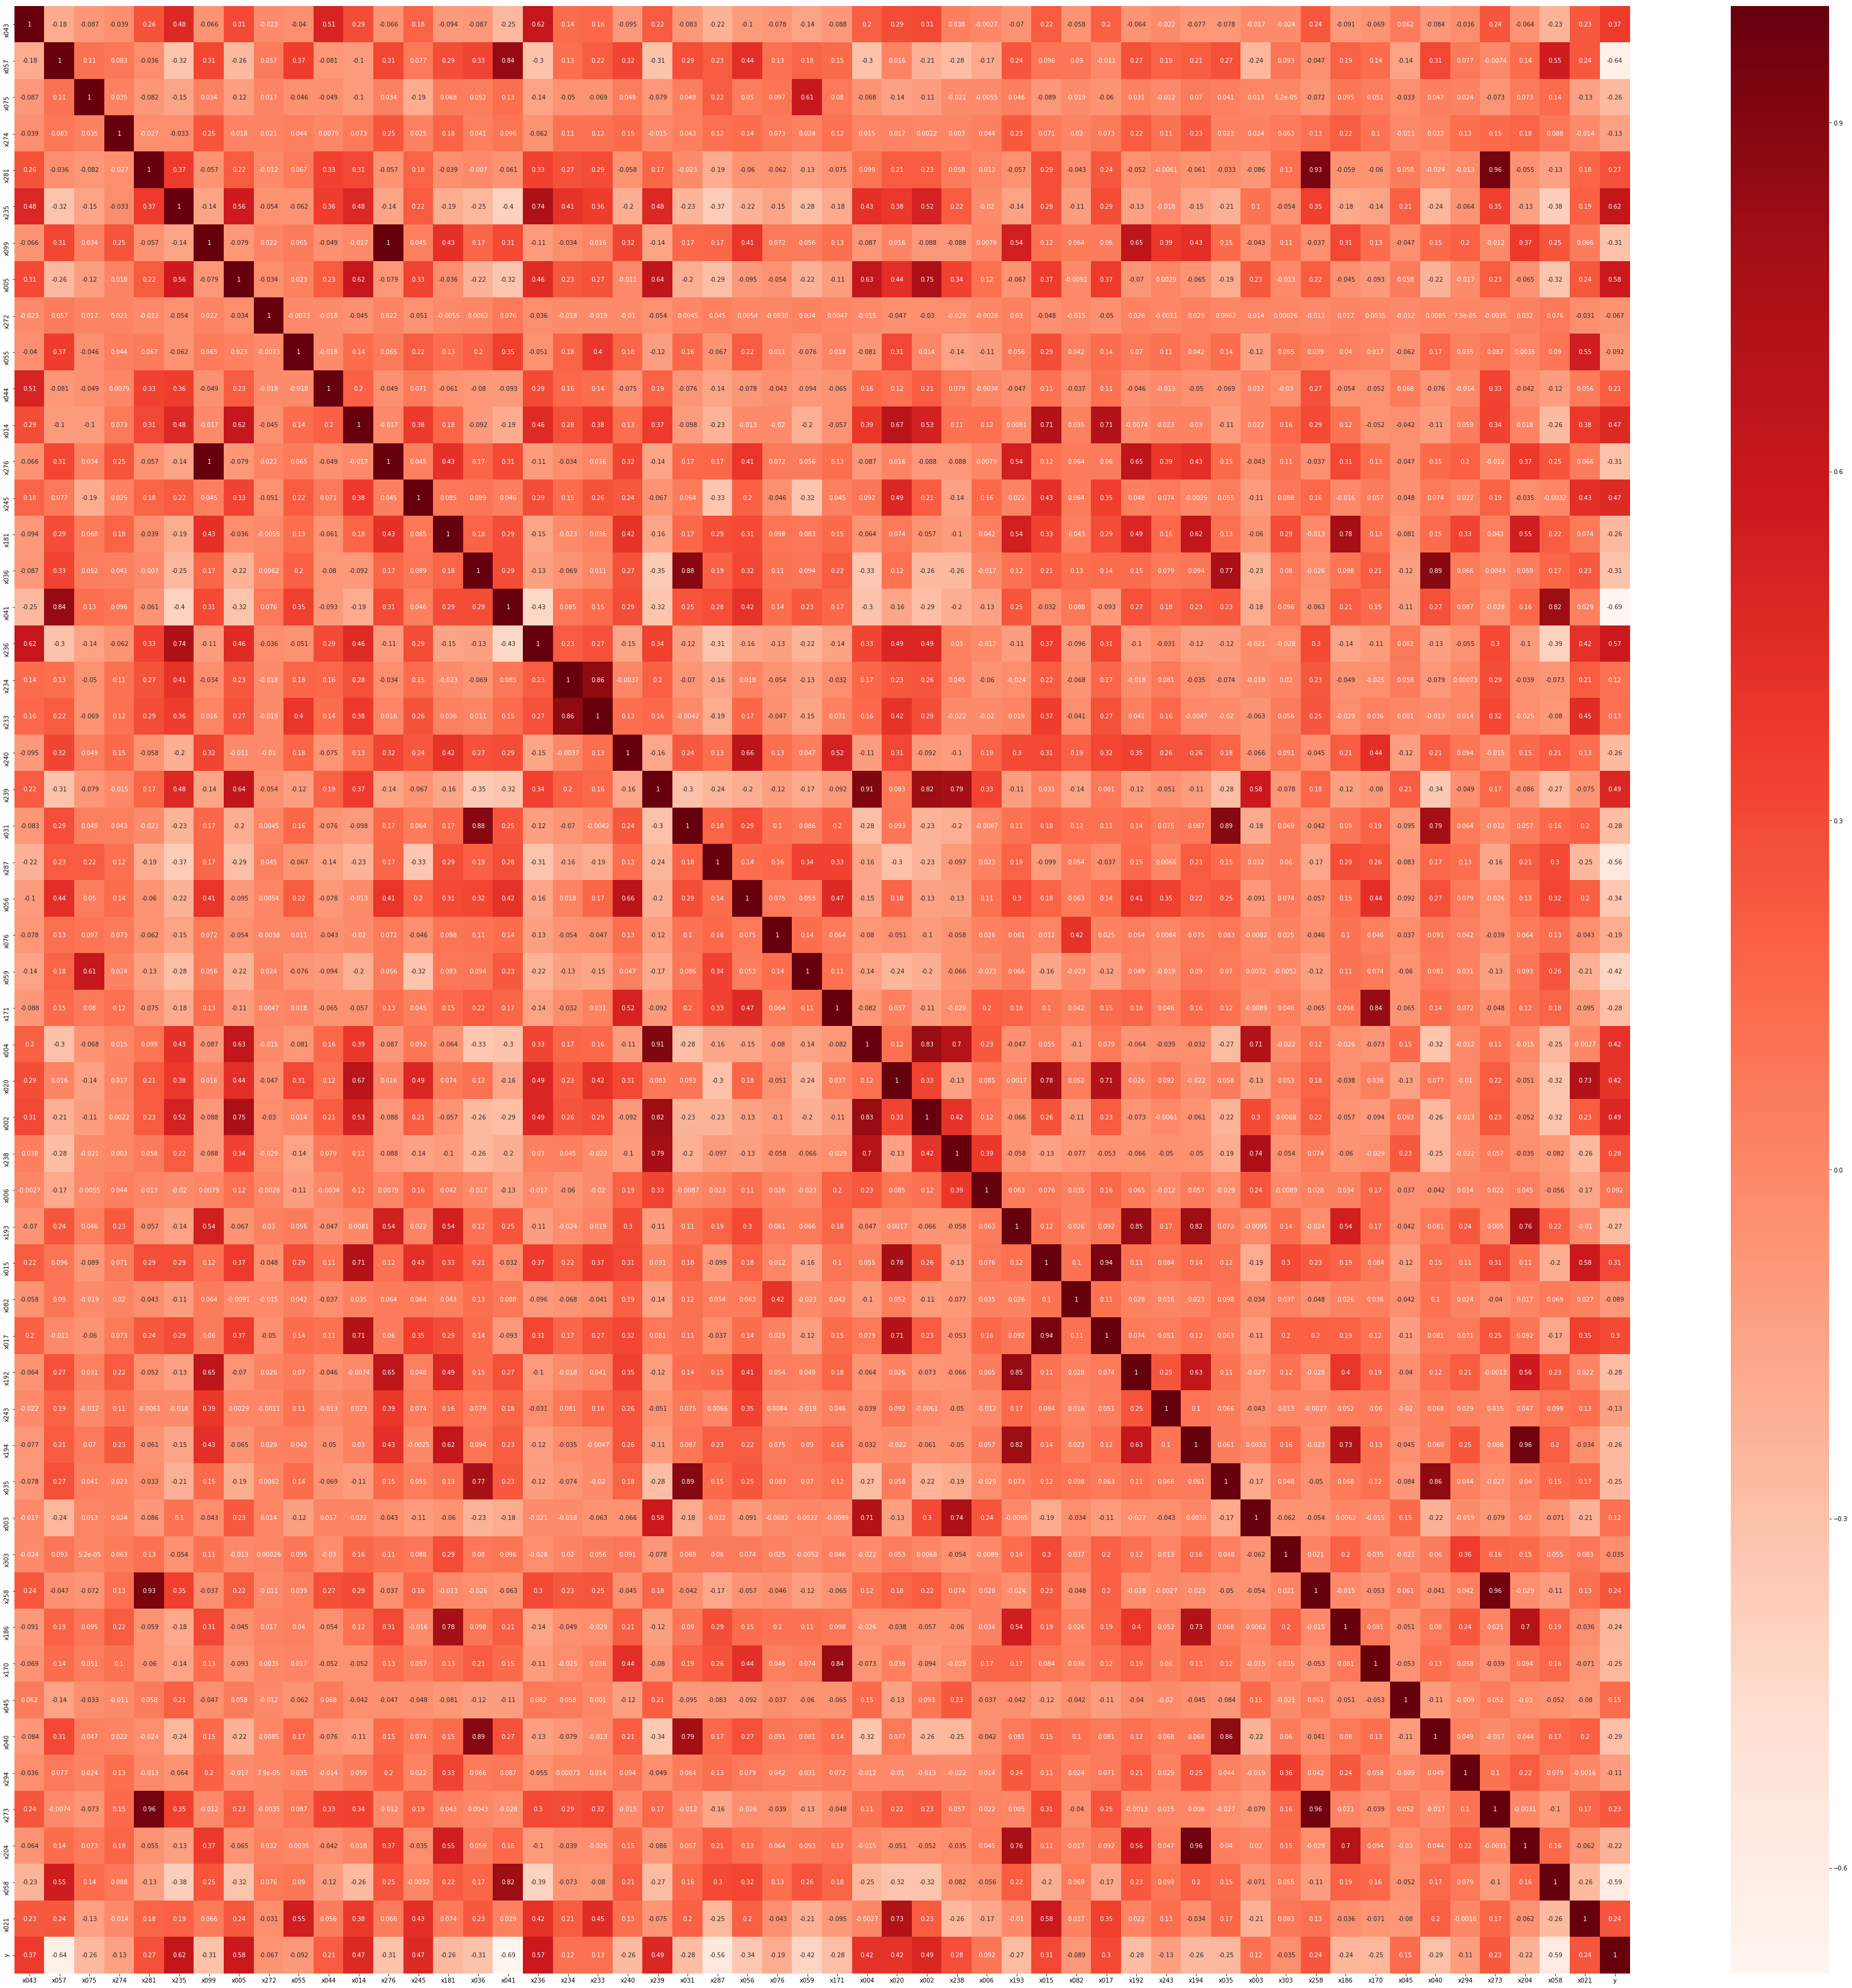

In [42]:
def corr_plot(df, target):
    
    """
    INPUT: A dataframe and a target variable
    OUTPUT: Removes correlated features and return a list of relevant features
    PURPOSE: To determine which features are most important based on 
    """
    import seaborn as sns
    
    plt.figure(figsize=(60,60))
    corr = df.corr()
    
    cor_target = abs(corr[target])
    relevant_features = cor_target[cor_target>0.5]
    sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
    plt.show();
    
    return relevant_features
    
impt_features = corr_plot(df2[relevant_features],'y')

In [44]:
impt_features

x057    0.636510
x235    0.620394
x005    0.575970
x041    0.690840
x236    0.572875
x287    0.562191
x058    0.586811
y       1.000000
Name: y, dtype: float64

### Conclusion

Bagging the model with a threshold of .001 yields the best RSME score with the time allotted for this project. A number of assumptions were made about the original underlying dataset given that a lookup table is not available to better understand the relevant features.